In [1]:
import os
import sys
from glob import glob
import requests
import random
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time

from albumentations import *

import matplotlib.pyplot as plt
import seaborn as sns
from albumentations import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class cfg:
    data_dir = '/opt/ml/input/data/train/'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [3]:
img_path = f'{cfg.data_dir}/images/003101_female_Asian_18/mask4.jpg'
img = np.array(Image.open(img_path))

img_paths = glob(os.path.join(f'{cfg.data_dir}/images', '**/*'))
random.shuffle(img_paths)

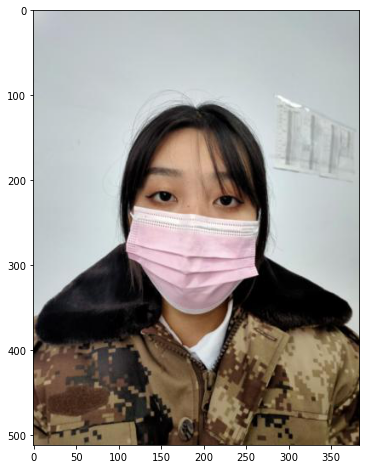

In [4]:
plt.figure(figsize=(16,8))
plt.imshow(img)

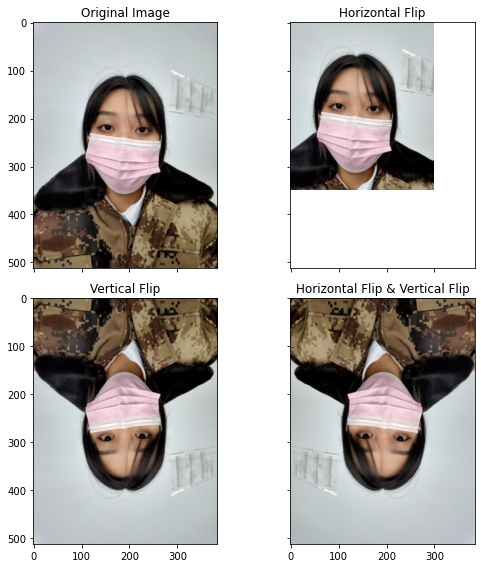

In [8]:
n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

axes[0][0].imshow(img)
axes[0][0].set_title(f'Original Image')

trfm = Compose([
            RandomCrop(350,300),
        ], p=1.0)
axes[0][1].imshow(trfm(image=img)['image'])
axes[0][1].set_title(f'Horizontal Flip')

trfm = Compose([
            VerticalFlip(p=1.0),
        ], p=1.0)
axes[1][0].imshow(trfm(image=img)['image'])
axes[1][0].set_title(f'Vertical Flip')

trfm = Compose([
            HorizontalFlip(p=1.0),
            VerticalFlip(p=1.0),
        ], p=1.0)
axes[1][1].imshow(trfm(image=img)['image'])
axes[1][1].set_title(f'Horizontal Flip & Vertical Flip')

plt.tight_layout()

NameError: name 'Random' is not defined

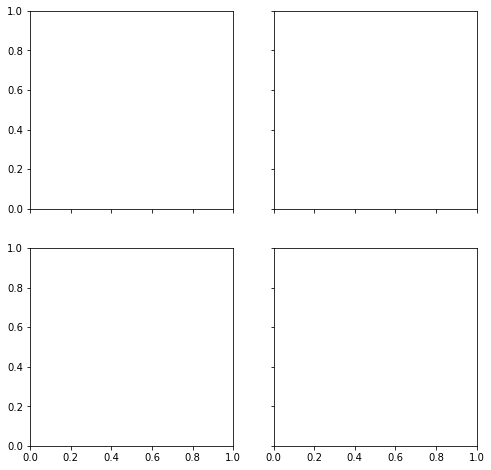

In [ ]:
n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

trfm = Compose([
            Random(p=0.5)
        ])
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//n_cols].imshow(trfm(image=img)['image'])

plt.tight_layout()

In [ ]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


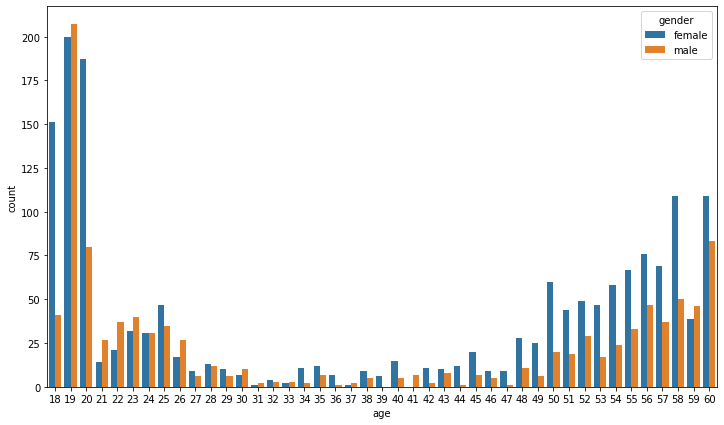

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.countplot(x='age',hue='gender',data=df)
plt.show()

In [ ]:
print(class2num)

{'incorrect_mask': 0, 'mask1': 1, 'mask2': 2, 'mask3': 3, 'mask4': 4, 'mask5': 5, 'normal': 6}


In [ ]:
def get_ext(img_dir, img_id):
    """
    학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
        ext: 이미지의 확장자
    """
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [ ]:
def get_img_stats(img_dir, img_ids):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [ ]:
img_info = get_img_stats(cfg.img_dir, df.path.values[:100])

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')


Total number of people is 2700
Total number of images is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384
RGB Mean: [0.55800916 0.51224077 0.47767341]
RGB Standard Deviation: [0.21817792 0.23804603 0.25183411]


In [ ]:
print(df["race"].unique())

['Asian']


In [ ]:
imgs = []
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)
for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
    imgs.append(img)
imgs = np.array(imgs)

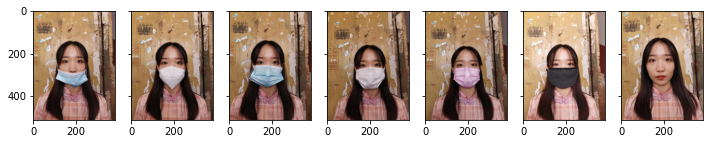

In [ ]:
fig, axes = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(12, 6))
for i in range(7):
    axes[i].imshow(imgs[i])

plt.show()

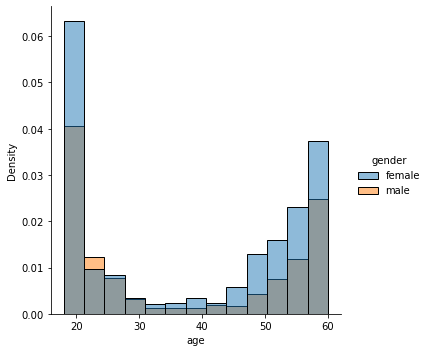

In [ ]:
sns.displot(df, x="age", hue="gender", stat="density")
plt.show()

In [ ]:
df_male = df.loc[df.gender=='male']
df_female = df.loc[df.gender=='female']
print(len(df_male),len(df_female))

1042 1658


In [ ]:
df_male.describe()

,age
count,1042.000000
mean,36.403071
std,17.066934
min,18.000000
25%,20.000000
50%,26.000000
75%,56.000000
max,60.000000


In [ ]:
df_female.describe()

,age
count,1658.000000
mean,38.528347
std,16.888379
min,18.000000
25%,20.000000
50%,44.000000
75%,55.000000
max,60.000000
